In [1]:
import cv2
import os
import numpy as np
import pickle
import time
%matplotlib inline 
from matplotlib import pyplot as plt
import pandas as pd

Krok 0: zebranie danych wejściowych

Zrodlo danych: Sentinel
Pobrane z wykorzystaniem: Creodias
Level-1C Liczba warstw 13
Kroki wykonane przed analizą:
Zmiana formatu warstw z jp2 na png ze względu na bezproblemową współpracę z OpenCV
Skompresowanie wszystkich warstw do rozdzielczości 1830x1830
Umieszczenie wszystkich warstw w katalogu Data

Krok 1: Klasyfikacja terenu:
Wykorzystano QGIS oraz wtyczkę QuickOSM
Z Open Street Map pobrano następujące warstwy:
natural water
landuse forest
landuse farmland
Ograniczono ich zasięg do zasięgu zdjęcia z Sentinel

TODO: Weryfikacja zgodności danych OSM i Sentinel i ewentualne naniesienie poprawek. Wstępne oględziny nie wykazały znacznych odstępst.

Krok 3. Wczytanie danych do Pythona

In [2]:
files = os.listdir('Data')
dimension = 1830 #to powinno się dać jakoś automatycznie wczytać.
data = np.zeros((dimension, dimension, len(files)))
bands_names = []
print('Reading data.',end='')
for i, file in enumerate(files):
    print('.',end='')
    bands_names.append(file[-7:-4])
    data[:, :, i] = cv2.imread(os.path.join('Data', file),
                               cv2.IMREAD_UNCHANGED)[:dimension,:dimension]
                         
print('OK')

Reading data..............OK


Wczytujemy klasyfikację

In [3]:
classes = cv2.imread('Classification.png')

Krok 4: Preprocessing

In [4]:
# Spłaszczamy dane wejściowe. W wierszach znajdą się kolejne piksele w kolumnach kolejne warstwy
X = data.reshape(dimension*dimension, len(files))
# Obcinamy odstające wartości. Wszystko obcinamy do średnia + trzy odchylenia standardowe
for i in range(X.shape[1]):
    X[:,i] = np.where(X[:,i] < np.mean(X[:,i]) + 3*np.std(X[:,i]), X[:,i], np.mean(X[:,i]) + 3*np.std(X[:,i]))
# Normalizujemy dane. W większości algorytmów będziemy liczyć gradient więc dobrze będzie gdy wartości będą znormalizowane
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
X = sc.fit_transform(X)

Krok 5: Wyliczenie wskaźnika wegetaci NDVI i wskaźnika wody NDWI. 

In [5]:
NDVI = (data[:,:,7] - data[:,:,3])/(data[:,:,7] + data[:,:,3])
NDWI = (data[:,:,2] - data[:,:,12])/(data[:,:,2] + data[:,:,12])

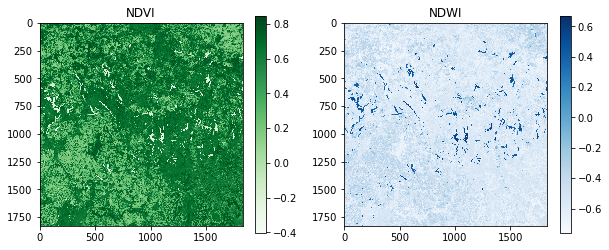

In [6]:
fig, axs = plt.subplots(figsize=(10,4), ncols=2)
NDVI_IM = axs[0].imshow(NDVI, cmap='Greens', interpolation='none')
axs[0].set_title('NDVI')
fig.colorbar(NDVI_IM, ax=axs[0])

NDWI_IM = axs[1].imshow(NDWI, cmap='Blues', interpolation='none')
axs[1].set_title('NDWI')
fig.colorbar(NDWI_IM, ax=axs[1])

plt.show()

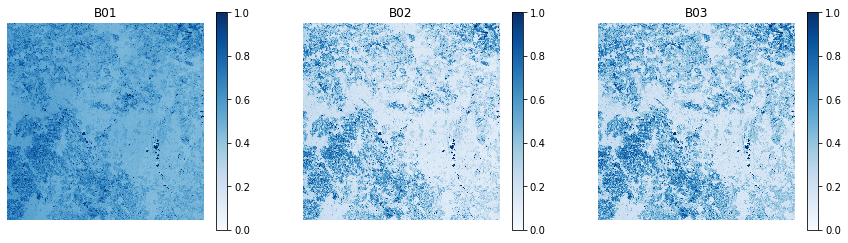

In [7]:
fig, axs = plt.subplots(figsize=(15,4), ncols=3, nrows=1)
for i in range(len(axs.flatten())):
        im = axs.flatten()[i].imshow(X[:,i].reshape(dimension,dimension), cmap='Blues', interpolation='none')
        axs.flatten()[i].set_axis_off()
        axs.flatten()[i].set_title(bands_names[i])
        fig.colorbar(im, ax=axs.flatten()[i])
plt.show()

fig, axs = plt.subplots(figsize=(15,4), ncols=3, nrows=1)
for i in range(len(axs.flatten())):
    axs.flatten()[i].hist(X[:,i],bins=100)
    axs.flatten()[i].set_title(bands_names[i])

In [8]:
time.sleep(15)

Klasyfikacja z wykorzystaniem samoorganizujących się map. Z wykorzystaniem implementacji MiniSom

In [9]:
from minisom import MiniSom
som = MiniSom(x=10, y=10, input_len=13,
              sigma=1.0, learning_rate=0.5)
som.random_weights_init(X)
som.train_random(data=X, num_iteration=20000, verbose=True)

 [   423 / 20000 ]   2% - 0:00:08 left 

 [   869 / 20000 ]   4% - 0:00:08 left 

 [  1375 / 20000 ]   7% - 0:00:07 left 

 [  1766 / 20000 ]   9% - 0:00:07 left 

 [  2242 / 20000 ]  11% - 0:00:07 left 

 [  2616 / 20000 ]  13% - 0:00:07 left 

 [  3087 / 20000 ]  15% - 0:00:07 left 

 [  3406 / 20000 ]  17% - 0:00:07 left 

 [  3795 / 20000 ]  19% - 0:00:07 left 

 [  4244 / 20000 ]  21% - 0:00:07 left 

 [  4798 / 20000 ]  24% - 0:00:06 left 

 [  5204 / 20000 ]  26% - 0:00:06 left 

 [  5630 / 20000 ]  28% - 0:00:06 left 

 [  6034 / 20000 ]  30% - 0:00:06 left 

 [  6413 / 20000 ]  32% - 0:00:06 left 

 [  6968 / 20000 ]  35% - 0:00:05 left 

 [  7380 / 20000 ]  37% - 0:00:05 left 

 [  7818 / 20000 ]  39% - 0:00:05 left 

 [  8349 / 20000 ]  42% - 0:00:05 left 

 [  8767 / 20000 ]  44% - 0:00:04 left 

 [  9222 / 20000 ]  46% - 0:00:04 left 

 [  9757 / 20000 ]  49% - 0:00:04 left 

 [ 10232 / 20000 ]  51% - 0:00:04 left 

 [ 10691 / 20000 ]  53% - 0:00:03 left 

 [ 11018 / 20000 ]  55% - 0:00:03 left 

 [ 11234 / 20000 ]  56% - 0:00:03 left 

 [ 11780 / 20000 ]  59% - 0:00:03 left 

 [ 12279 / 20000 ]  61% - 0:00:03 left 

 [ 12715 / 20000 ]  64% - 0:00:03 left 

 [ 13152 / 20000 ]  66% - 0:00:02 left 

 [ 13565 / 20000 ]  68% - 0:00:02 left 

 [ 14114 / 20000 ]  71% - 0:00:02 left 

 [ 14452 / 20000 ]  72% - 0:00:02 left 

 [ 14906 / 20000 ]  75% - 0:00:02 left 

 [ 15395 / 20000 ]  77% - 0:00:01 left 

 [ 15787 / 20000 ]  79% - 0:00:01 left 

 [ 16216 / 20000 ]  81% - 0:00:01 left 

 [ 16597 / 20000 ]  83% - 0:00:01 left 

 [ 17182 / 20000 ]  86% - 0:00:01 left 

 [ 17657 / 20000 ]  88% - 0:00:01 left 

 [ 18133 / 20000 ]  91% - 0:00:00 left 

 [ 18556 / 20000 ]  93% - 0:00:00 left 

 [ 18910 / 20000 ]  95% - 0:00:00 left 

 [ 19270 / 20000 ]  96% - 0:00:00 left 

 [ 19756 / 20000 ]  99% - 0:00:00 left 

 [ 20000 / 20000 ] 100% - 0:00:00 left 


 quantization error: 0.16856912079182879


Wizualizacja mapowania

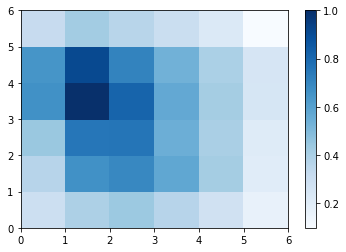

In [10]:
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T, cmap='Blues')
colorbar()
show()

In [11]:
qnt = som.quantization(X)
clustered = np.sum(qnt, axis=1)
clustered = clustered.reshape((dimension,dimension))
classes = np.unique(clustered)

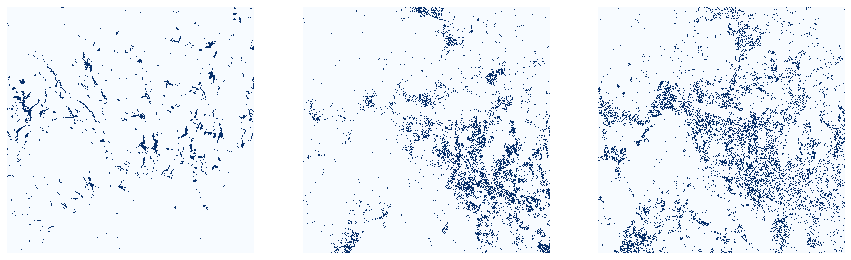

In [12]:
fig, axs = plt.subplots(figsize=(15,8), ncols=3, nrows=1)
for i, ax in enumerate(axs.flatten()):
    temp_img = np.where(clustered == classes[i],255,0)
    ax.axis("Off")
    ax.imshow(temp_img.reshape(dimension,dimension), cmap='Blues', interpolation='none')
plt.show()

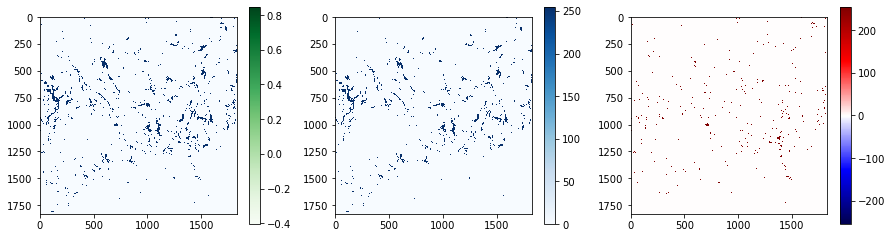

In [13]:
fig, axs = plt.subplots(figsize=(15,4), ncols=3)
predicted = axs[0].imshow(np.where(clustered == classes[0],255,0), cmap='Blues', interpolation='none')
fig.colorbar(NDVI_IM, ax=axs[0])

NDWI_IM = axs[1].imshow(np.where(NDWI > 0,255,0), cmap='Blues', interpolation='none')
fig.colorbar(NDWI_IM, ax=axs[1])

difference = axs[2].imshow(np.where(clustered == classes[0],255,0) - np.where(NDWI > 0,255,0) , cmap='seismic', interpolation='none')
fig.colorbar(difference, ax=axs[2])

plt.show()

status = np.where(clustered == classes[1],255,0) - np.where(NDWI > 0,255,0)
print(np.count_nonzero(status!=0)/(dimension*dimension))

In [14]:
classes = cv2.imread('Classification.png')
classes = classes[:dimension,:dimension]

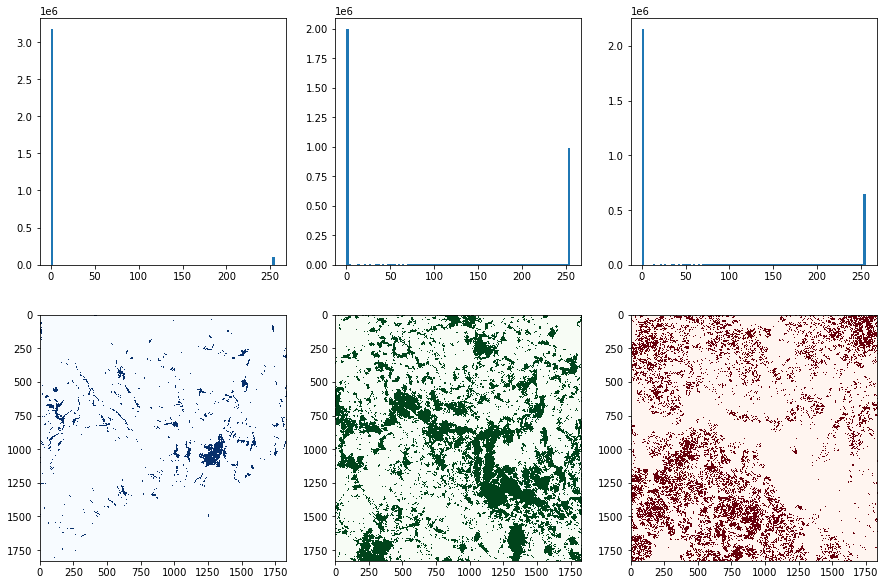

In [15]:
fig, axs = plt.subplots(figsize=(15,10), ncols=3, nrows=2)
axs.flatten()[0].hist(classes[...,0].flatten(), bins=100)
axs.flatten()[1].hist(classes[...,1].flatten(), bins=100)
axs.flatten()[2].hist(classes[...,2].flatten(), bins=100)
axs.flatten()[3].imshow(np.where(classes[...,0] < 250,0,1), cmap='Blues', interpolation='none')
axs.flatten()[4].imshow(np.where(classes[...,1] < 250,0,1), cmap='Greens', interpolation='none')
axs.flatten()[5].imshow(np.where(classes[...,2] < 250,0,1), cmap='Reds', interpolation='none')
plt.show()

In [16]:
Y_real = np.array(classes.reshape((dimension*dimension,3)))
Y_real = (Y_real/255).astype(int)
print(Y_real)

[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 1 0]
 [0 1 0]
 [0 1 0]]


In [17]:
Y_pred = clustered.reshape((dimension*dimension,1))
print(Y_pred)

[[7.93110677]
 [7.31325495]
 [6.84006673]
 ...
 [3.76808403]
 [3.76808403]
 [3.76808403]]


In [18]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(Y_pred)
Y_pred_enc = enc.transform(Y_pred)

In [20]:
accuracy = np.zeros((100,3))
for j in range(3):
    a = ((Y_real[:,j:j+1]+1) - Y_pred_enc*2).astype(int)
    for i in range(100):
        accuracy[i,j] = np.around((a.shape[0] - np.count_nonzero(a[:,i]))/np.count_nonzero(Y_real[:,j:j+1]),2)
accuracy

array([[0.78, 0.  , 0.  ],
       [0.09, 0.22, 0.  ],
       [0.07, 0.33, 0.  ],
       [0.01, 0.01, 0.  ],
       [0.  , 0.  , 0.01],
       [0.01, 0.16, 0.  ],
       [0.01, 0.03, 0.  ],
       [0.  , 0.07, 0.  ],
       [0.  , 0.02, 0.  ],
       [0.  , 0.04, 0.  ],
       [0.  , 0.02, 0.  ],
       [0.  , 0.04, 0.01],
       [0.  , 0.01, 0.01],
       [0.  , 0.01, 0.04],
       [0.  , 0.01, 0.01],
       [0.  , 0.  , 0.05],
       [0.  , 0.01, 0.02],
       [0.  , 0.  , 0.01],
       [0.  , 0.  , 0.02],
       [0.  , 0.  , 0.01],
       [0.  , 0.  , 0.03],
       [0.  , 0.  , 0.01],
       [0.  , 0.  , 0.01],
       [0.  , 0.  , 0.04],
       [0.  , 0.  , 0.02],
       [0.  , 0.  , 0.05],
       [0.  , 0.  , 0.02],
       [0.  , 0.  , 0.03],
       [0.  , 0.  , 0.08],
       [0.  , 0.  , 0.04],
       [0.  , 0.  , 0.07],
       [0.  , 0.  , 0.04],
       [0.  , 0.  , 0.09],
       [0.  , 0.  , 0.12],
       [0.  , 0.  , 0.06],
       [0.  , 0.  , 0.09],
       [0.  , 0.  , 0.  ],
 